In [1]:
# reload all modules before executing user code
%load_ext autoreload
%autoreload 2

In [2]:
import cv2
from ultralytics import YOLO
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import sys
sys.path.append(os.path.abspath('..'))

from src.const import *
from src.morph import *

In [3]:
DISTANCE_HULL = 10

range_white = 45

lower_white = [max(0, c - range_white) for c in WHITE_CHESS]
upper_white = [min(240, c + range_white) for c in WHITE_CHESS]

"""
Custom YOLO train over Roboflow dataset on corner of chessboard
"""
# model = YOLO(r'C:\Users\Student11\Documents\git\ELEN-CV\project\yolo\yolo11n_custom6h.pt')
model = YOLO(r'..\weights\best.pt')
model2 = YOLO(r'..\weights\best11m.pt')

In [4]:
def double_detect_yolo(frame):

    frame_height, frame_width = frame.shape[:2]

    hull, combined_contour = external_border(frame, lower_white, upper_white)

    # draw the convex hull on the frame
    cv2.drawContours(frame, [hull], -1, (0, 255, 0), 3)

    # scale factor horizontal and vertical
    fx = 640 / frame_width
    fy = 640 / frame_height
    
    frame_resized = cv2.resize(frame, (640, 640), interpolation=cv2.INTER_AREA)

    # Result of the corners detection with YOLO
    results = model.track(source=frame, persist=True, verbose=False, show=False, tracker="bytetrack.yaml", conf=0.1, iou=0.1)
    results2 = model2.track(source=frame, persist=True, verbose=False, show=False, tracker="bytetrack.yaml", conf=0.1, iou=0.1)
    
    results.extend(results2)
    
    results_resized = model.track(source=frame_resized, persist=True, verbose=False, show=False, tracker="bytetrack.yaml", conf=0.1, iou=0.1)
    results2_resized = model2.track(source=frame_resized, persist=True, verbose=False, show=False, tracker="bytetrack.yaml", conf=0.1, iou=0.1)
    
    results_resized.extend(results2_resized)

    bbox_data = []
    
    for result in results_resized:
        for box in result.boxes:
            # Resized frame coordinates
            x1, y1, x2, y2 = box.xyxy[0].tolist()
            confidence = box.conf[0].item()
            # check box is already tracked if not, no id
            if box.id is not None:
                label = int(box.id.item())
            else:
                label = 99
            label_text = f"{confidence:.2f}"
            
            # Map to original frame coordinates
            x1_original, y1_original = x1 / fx, y1 / fy
            x2_original, y2_original = x2 / fx, y2 / fy
            
            # Calculate the center of the bounding box
            cx_resized, cy_resized = (x1 + x2) / 2, (y1 + y2) / 2
            cx_original, cy_original = cx_resized / fx, cy_resized / fy
            
            distance = cv2.pointPolygonTest(hull, (cx_original, cy_original), True)
            if distance < -DISTANCE_HULL:
                continue  # Skip this prediction if the center is not inside the hull or within 10 pixels

            bbox_data.append((cx_original, cy_original, x1_original, y1_original, x2_original, y2_original))  # Store center and box dimensions

            # Visualize the results on the original frame
            # cv2.circle(frame, (int(cx_original), int(cy_original)), 3, BLUE, -1)
            cv2.rectangle(frame, (int(x1_original), int(y1_original)), (int(x2_original), int(y2_original)), ORANGE, 2)
            # cv2.putText(frame, label_text, (int(x1_original), int(y1_original) - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, BLACK, 2)

    for result in results:
        for box in result.boxes:
            x1, y1, x2, y2 = box.xyxy[0].tolist()
            confidence = box.conf[0].item()
            # check box is already tracked if not, no id
            if box.id is not None:
                label = int(box.id.item())
            else:
                label = 99
            label_text = f"{confidence:.2f}"

            cx, cy = (x1 + x2) / 2, (y1 + y2) / 2  # Center of the bounding box

            # Check if the center of the bounding box is inside the hull or within 10 pixels
            distance = cv2.pointPolygonTest(hull, (cx, cy), True)
            if distance < -DISTANCE_HULL:
                continue 
                
            bbox_data.append((cx, cy, x1, y1, x2, y2))

            # Visualize the results on the original frame
            cv2.circle(frame, (int(cx), int(cy)), 3, BLUE, -1)
            cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), ORANGE, 2)
            cv2.putText(frame, label_text, (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, BLACK, 2)         

    return bbox_data, frame

def cluster_boxes(bbox):

    # Group bounding boxes using DBSCAN with a maximum distance of 100 pixels

    bbox_centers = np.array([[data[0], data[1]] for data in bbox])  # Only centers
    clustering = DBSCAN(eps=200, min_samples=1).fit(bbox_centers)  # eps = 100 pixels

    clusters = {}
    for idx, label in enumerate(clustering.labels_):
        if label not in clusters:
            clusters[label] = []
        # Add full bounding box data to the cluster
        clusters[label].append(bbox[idx])  

    # Compute the average bounding box for each cluster
    averaged_bboxes = []
    for cluster_id, boxes in clusters.items():
        # Average the coordinates of the bounding boxes in the cluster
        avg_x1 = int(np.mean([box[2] for box in boxes]))
        avg_y1 = int(np.mean([box[3] for box in boxes]))
        avg_x2 = int(np.mean([box[4] for box in boxes]))
        avg_y2 = int(np.mean([box[5] for box in boxes]))
        # Center of the averaged bounding box
        avg_cx, avg_cy = (avg_x1 + avg_x2) // 2, (avg_y1 + avg_y2) // 2  
        averaged_bboxes.append((avg_x1, avg_y1, avg_x2, avg_y2, avg_cx, avg_cy))

    return averaged_bboxes

def id_corner_chessboard(corners, clustered_bboxes, frame):

    for bbox in clustered_bboxes:

        x1, y1, x2, y2, cx, cy = bbox
        label_text = ""
        
        
        # Determine which corner the center belongs to
        if cx < frame.shape[1] / 2 and cy < frame.shape[0] / 2:
            corners["h8"][0], corners["h8"][1] = cx, cy
            label_text += " h8"
            
        elif cx >= frame.shape[1] / 2 and cy < frame.shape[0] / 2:
            corners["h1"][0], corners["h1"][1] = cx, cy
            label_text += " h1"

        elif cx < frame.shape[1] / 2 and cy >= frame.shape[0] / 2:
            corners["a8"][0], corners["a8"][1] = cx, cy
            label_text += " a8"

        elif cx >= frame.shape[1] / 2 and cy >= frame.shape[0] / 2:
            corners["a1"][0], corners["a1"][1] = cx, cy
            label_text += " a1"
            
        cv2.circle(frame, (int(cx), int(cy)), 3, BLUE, -1)
        cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), GREEN, 2)
        cv2.putText(frame, label_text, (int(x1), int(y1)-10), cv2.FONT_HERSHEY_SIMPLEX, 1, BLACK, 2)

    return corners

def corner_id_yolo(frame):

    # Initialize corner coordinates
    corners = {
        "h8": [None, None],
        "h1": [None, None],
        "a8": [None, None],
        "a1": [None, None]
    }

    bbox_data, frame = double_detect_yolo(frame)

    clustered_boxes = cluster_boxes(bbox_data)

    if len(clustered_boxes) >= 4:
        centroid_x = sum([c[4] for c in clustered_boxes]) / len(clustered_boxes)
        centroid_y = sum([c[5] for c in clustered_boxes]) / len(clustered_boxes)

        cv2.circle(frame, (int(centroid_x), int(centroid_y)), 7, RED, -1)

    corners = id_corner_chessboard(corners, clustered_boxes, frame) 

    # for corner, coord in corners.items():
        # if all(c is None for c in coord):
            # print(f"{corner}: (x,x)", end=" | ")
        # else:
            # print(f"{corner}:({coord[0]},{coord[1]})", end=" | ")
    # print()

    return corners

def warp_image(frame, corners, board_size=(800, 800)):
    
    # define the destination points for the transformation (clockwise from top-left)
    dest_points = np.array([
                            [0, 0],
                            [board_size[0] - 1, 0],
                            [board_size[0] - 1, board_size[1] - 1],
                            [0, board_size[1] - 1]
                        ], dtype="float32")

    # reorder corners for clockwise from top-left
    src_pts = np.array([
                        [corners["h8"][0], corners["h8"][1]],
                        [corners["h1"][0], corners["h1"][1]],
                        [corners["a1"][0], corners["a1"][1]],
                        [corners["a8"][0], corners["a8"][1]] 
                    ], dtype=np.float32)

    perspect_matrix = cv2.getPerspectiveTransform(src_pts, dest_points)
    warped_image = cv2.warpPerspective(frame, perspect_matrix, board_size)

    return warped_image

def segmented_grid_chessboard(warped_frame):

    h, w = warped_frame.shape[:2]

    # convert to grayscale and detect edges
    gray = cv2.cvtColor(warped_frame, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)

    # automatic Canny thresholds based on median
    med = np.median(blur)
    lower = int(max(0, 0.66 * med))
    upper = int(min(255, 1.33 * med))
    edges = cv2.Canny(blur, lower, upper)

    # probabilistic Hough line transform
    lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=80,
                            minLineLength=60, maxLineGap=20)
    
    segs = lines.reshape(-1, 4)
    # compute direction vectors of each segment by (x2 - x1, y2 - y1)
    vecs = segs[:, 2:4] - segs[:, :2]
    print(vecs.shape)  # (N, 2) : N vectors, each with 2 components (dx, dy)

    # compute angle of each segment
    dx, dy = vecs[:, 0].astype(float), vecs[:, 1].astype(float)
    angles = np.arctan2(dy, dx)

    """
    extend detected nearly-vertical and nearly-horizontal segments 
    to full image borders to form a grid
    """
    
    class_tol = np.deg2rad(1)  # classify lines within 15 degrees as horizontal/vertical

    # get indices of lines with +- 15dg vert or horiz
    vert_idx = np.where(np.abs(np.abs(angles) - np.pi/2) < class_tol)[0]
    horiz_idx = np.where(np.abs(angles) < class_tol)[0]
    print(f"Number of vertical lines: {len(vert_idx)}")
    print(f"Number of horizontal lines: {len(horiz_idx)}")

    # use segs to define a x-y axis system based on midpoints of detected segments
    xs = np.array([(segs[i, 0] + segs[i, 2]) / 2.0 for i in vert_idx]) if vert_idx.size else np.array([])
    ys = np.array([(segs[i, 1] + segs[i, 3]) / 2.0 for i in horiz_idx]) if horiz_idx.size else np.array([])

    # cluster close lines to avoid duplicate nearby grid lines
    def cluster_1d(vals, eps=10):
        if vals.size == 0:
            return np.array([])
        vals = vals.reshape(-1, 1)
        clustering = DBSCAN(eps=eps, min_samples=1).fit(vals)
        clusters = []
        for lab in np.unique(clustering.labels_):
            members = vals[clustering.labels_ == lab].flatten()
            clusters.append(members.mean())
        return np.array(sorted(clusters))

    x_lines = cluster_1d(xs, eps=12)
    y_lines = cluster_1d(ys, eps=12)
    print(f"Number of vertical lines clustered: {len(x_lines)}")
    print(f"Number of horizontal lines clustered: {len(y_lines)}")

    if len(x_lines) < 9 or len(y_lines) < 9:
        # extrapolate missing lines to ensure at least 9 lines in each direction
        print("Not enough grid lines detected, extrapolating missing lines...")
        if len(x_lines) < 9 and len(x_lines) >= 2:
            x_step = np.median(np.diff(x_lines))
            while len(x_lines) < 9:
                if len(x_lines) < 9:
                    x_lines = np.insert(x_lines, 0, x_lines[0] - x_step)
                if len(x_lines) < 9:
                    x_lines = np.append(x_lines, x_lines[-1] + x_step)
        if len(y_lines) < 9 and len(y_lines) >= 2:
            y_step = np.median(np.diff(y_lines))
            while len(y_lines) < 9:
                if len(y_lines) < 9:
                    y_lines = np.insert(y_lines, 0, y_lines[0] - y_step)
                if len(y_lines) < 9:
                    y_lines = np.append(y_lines, y_lines[-1] + y_step)
    print(f"Final vertical lines: {len(x_lines)}")
    print(f"Final horizontal lines: {len(y_lines)}")

    # compute intersection points of the grid lines
    inters_pts = []
    for xv in x_lines:
        for yv in y_lines:
            xi = int(round(np.clip(xv, 0, w-1)))
            yi = int(round(np.clip(yv, 0, h-1)))
            inters_pts.append((xi, yi))

    external_pts = [
        (int(round(np.clip(x_lines[0], 0, w-1))), int(round(np.clip(y_lines[0], 0, h-1)))),
        (int(round(np.clip(x_lines[-1], 0, w-1))), int(round(np.clip(y_lines[0], 0, h-1)))),
        (int(round(np.clip(x_lines[0], 0, w-1))), int(round(np.clip(y_lines[-1], 0, h-1)))),
        (int(round(np.clip(x_lines[-1], 0, w-1))), int(round(np.clip(y_lines[-1], 0, h-1))))
    ]

    min_x, max_x, min_y, max_y = external_pts[0][0], external_pts[3][0], external_pts[0][1], external_pts[3][1]

    line_img = warped_frame.copy()

    for i, (x1, y1, x2, y2) in enumerate(segs):
        cv2.line(line_img, (int(x1), int(y1)), (int(x2), int(y2)), RED, 5)

    for xv in x_lines:
        x = int(round(np.clip(xv, 0, w-1)))
        # cv2.line(line_img2, (x, 0), (x, h-1), BLUE, 2)
        cv2.line(warped_frame, (x, min_y), (x, max_y), BLUE, 2)

    for yv in y_lines:
        y = int(round(np.clip(yv, 0, h-1)))
        # cv2.line(warped_frame, (0, y), (w-1, y), BLUE, 2)
        cv2.line(warped_frame, (min_x, y), (max_x, y), BLUE, 2)

    for (xi, yi) in inters_pts:
        cv2.circle(warped_frame, (xi, yi), 6, ORANGE, -1)


    for i, (xi, yi) in enumerate(external_pts):
        cv2.circle(warped_frame, (xi, yi), 6, BLACK, 4)

    axs, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(cv2.cvtColor(line_img, cv2.COLOR_BGR2RGB))
    ax[0].set_title('Detected Lines')
    ax[1].imshow(cv2.cvtColor(warped_frame, cv2.COLOR_BGR2RGB))
    ax[1].set_title('Grid Intersections')
    plt.show()

    return inters_pts, external_pts

def cleaning_cell_chessboard(warped_frame):

    warped_frame = cv2.cvtColor(warped_frame, cv2.COLOR_BGR2RGB)

    range_white = 45        
    range_black = 45        
    lower_white = [max(0, c - range_white) for c in WHITE_CHESS]
    upper_white = [min(240, c + range_white) for c in WHITE_CHESS] 
    lower_black = [max(0, c - range_black) for c in BLACK_CHESS2] 
    upper_black = [min(240, c + range_black) for c in BLACK_CHESS2]

    # exclude (put at 0=black) white pixels in the specified range of chessboard
    exclude_white_mask = exclude_color_mask(warped_frame, lower_white, upper_white)

    # removes white areas from the image
    exclude_white_frame = cv2.bitwise_and(warped_frame, warped_frame, mask=exclude_white_mask)

    # exclude (put at 0=black) black pixels in the specified range of chessboard
    exclude_black_mask = exclude_color_mask(warped_frame, lower_black, upper_black)

    # removes black areas from the image
    exclude_black_frame = cv2.bitwise_and(warped_frame, warped_frame, mask=exclude_black_mask)

    exclude_white_black = cv2.bitwise_and(exclude_white_frame, exclude_black_frame)

    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
    axs[0,0].imshow(exclude_white_mask)
    axs[0,0].set_title('Exclude White Mask')
    axs[0,1].imshow(exclude_white_frame)
    axs[0,1].set_title('Exclude White Frame')
    axs[1,0].imshow(exclude_black_mask)
    axs[1,0].set_title('Exclude Black Mask')
    axs[1,1].imshow(exclude_black_frame)
    axs[1,1].set_title('Exclude Black Frame')
    plt.show()

    clean_exclude_white_black = dilate(erode(exclude_white_black, 3, 8), 3, 10)

    return clean_exclude_white_black

def get_grid_cells_colors(clean_chessboard, inters_pts, external_pts, warped_frame):
    """
    Get the average color of each cell in the chessboard grid.
    Args:
        clean_chessboard: The cleaned chessboard image (only pawns are visible, rest is black).
        inters_pts: List of intersection points of the 8x8 grid lines.
        external_pts: List of external corner points of the 8x8 grid's chessboard.
    """
    # build 8x8 cell colors using the 9x9 intersection points
    cell_colors = []

    pts = np.array(inters_pts, dtype=np.int32)
    h_img, w_img = clean_chessboard.shape[:2]

    # detect ordering of inters_pts (column-major vs row-major)
    # if first 9 points share same x -> column-major (like current inters_pts sample)
    col_major = np.std(pts[:9, 0].astype(np.float32)) < 1.0

    roi_scale = 0.6  # fraction of cell size to sample (keeps ROI well inside the cell)

    for r in range(8):  # row (y)
        for c in range(8):  # col (x)
            if col_major:
                tl = pts[c * 9 + r]
                tr = pts[(c + 1) * 9 + r]
                bl = pts[c * 9 + (r + 1)]
                br = pts[(c + 1) * 9 + (r + 1)]
            else:
                tl = pts[r * 9 + c]
                tr = pts[r * 9 + (c + 1)]
                bl = pts[(r + 1) * 9 + c]
                br = pts[(r + 1) * 9 + (c + 1)]

            # compute cell center and approximate cell width/height

            # projection make pawns on left cols, strecthed towards up-left corner
            # projection make pawns on right cols, strecthed towards up-right corner
            # addjust center computation accordingly
            if c < 4:
                cx = int((tl[0] + tr[0]) / 2.0 + (bl[0] + br[0]) / 2.0 * 0.7)
                cy = int((tl[1] + tr[1]) / 2.0 + (bl[1] + br[1]) / 2.0 * 0.5)
            if c >= 4:
                cx = int((tl[0] + tr[0]) / 2.0 + (bl[0] + br[0]) / 2.0 * 0.3)
                cy = int((tl[1] + tr[1]) / 2.0 + (bl[1] + br[1]) / 2.0 * 0.7)
            cell_w = int(np.linalg.norm(tr - tl))
            cell_h = int(np.linalg.norm(bl - tl))
            base = max(1, int(min(cell_w, cell_h) * roi_scale))

            x1 = max(0, cx - base // 2)
            x2 = min(w_img, cx + base // 2)
            y1 = max(0, cy - base // 2)
            y2 = min(h_img, cy + base // 2)

            roi = clean_chessboard[y1:y2, x1:x2]
            if roi.size == 0:
                # fallback to small 3x3 area at center
                print(f"Empty ROI for cell ({r}, {c}), using 3x3 fallback.")
                x1 = max(0, cx - 1); x2 = min(w_img, cx + 2)
                y1 = max(0, cy - 1); y2 = min(h_img, cy + 2)
                roi = clean_chessboard[y1:y2, x1:x2]

            # handle both single-channel and 3-channel images
            if roi.ndim == 3 and roi.shape[2] == 3:
                print(f"Cell ({r}, {c}) ROI shape: {roi.shape} : 3-channel")
                mask = np.any(roi > 0, axis=2)
                if np.any(mask):
                    mean_col = tuple(np.round(np.mean(roi[mask], axis=0), 6).tolist())
                else:
                    mean_col = tuple(np.round(np.mean(roi.reshape(-1, 3), axis=0), 6).tolist())
            else:
                # single channel
                print(f"Cell ({r}, {c}) ROI shape: {roi.shape} : single-channel")
                mask = roi > 0
                if np.any(mask):
                    m = float(np.mean(roi[mask]))
                else:
                    m = float(np.mean(roi)) if roi.size else 0.0
                mean_col = (m, m, m)  # keep 3-tuple for consistency

            # draw the cell polygon contour on the warped_frame and show a small filled patch with the mean color
            pts_poly_cell = np.array([tl, tr, br, bl], dtype=np.int32)

            # draw only the contour of the ROI on the warped frame
            cv2.polylines(warped_frame, [pts_poly_cell], isClosed=True, color=BLACK, thickness=2)

            pts_poly_roi = np.array([[x1, y1], [x2, y1], [x2, y2], [x1, y2]], dtype=np.int32)
            cv2.polylines(warped_frame, [pts_poly_roi], isClosed=True, color=ORANGE, thickness=3)

            # # convert mean color (likely RGB from clean_chessboard) to BGR for drawing on warped_frame
            # mean_col_bgr = tuple(int(round(c)) for c in mean_col[::-1])

            # # small color patch at the bottom-left inside the cell (with bounds checking)
            # patch_size = max(12, int(min(cell_w, cell_h) * 0.2))
            # margin = 5

            # # anchor patch to left inside cell
            # px1 = int(max(0, tl[0] + margin))
            # px2 = int(min(w_img - 1, px1 + patch_size))
            # if px2 - px1 < patch_size:
            #     px1 = int(max(0, px2 - patch_size))

            # # anchor patch to bottom inside cell
            # py2 = int(min(h_img - 1, br[1] - margin))
            # py1 = int(max(0, py2 - patch_size))

            # cv2.rectangle(warped_frame, (px1, py1), (px2, py2), mean_col_bgr, thickness=-1)
            # # optional thin border for visibility
            # cv2.rectangle(warped_frame, (px1, py1), (px2, py2), BLACK, thickness=1)

            # annotate mean color value (as integer RGB) near the patch
            # # txt = f"{tuple(int(round(c)) for c in mean_col)}"
            # # cv2.putText(warped_frame, txt, (px1, max(0, py2 + 15)), cv2.FONT_HERSHEY_SIMPLEX, 0.45, BLACK, 1, cv2.LINE_AA)

            cell_colors.append(mean_col)

    plt.figure(figsize=(8,8))
    plt.imshow(cv2.cvtColor(warped_frame, cv2.COLOR_BGR2RGB))
    plt.title('Chessboard Cells with Average Colors')
    plt.show()

    return cell_colors


Frame Rate :  29 frames per second
Frame count :  12457.0
Frame jump :  2491.4
Frame width :  1920.0
Frame height :  1080.0
corners 
 {'h8': [None, None], 'h1': [1288, 337], 'a8': [242, 815], 'a1': [1527, 809]}


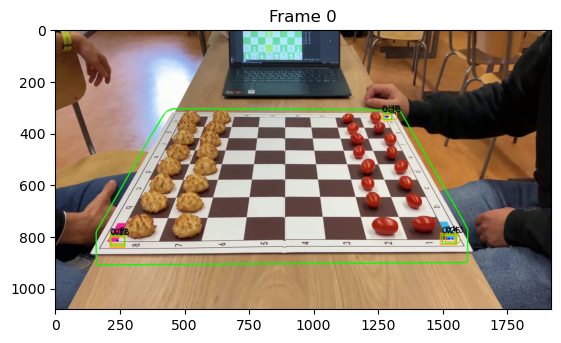

corners 
 {'h8': [496, 324], 'h1': [1290, 338], 'a8': [242, 815], 'a1': [1527, 809]}
pts 
 [[ 496  324]
 [1290  338]
 [1527  809]
 [ 242  815]]


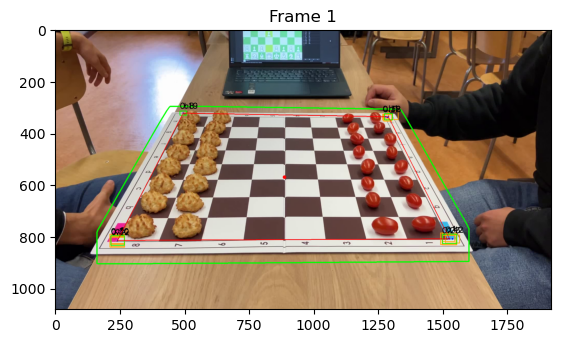

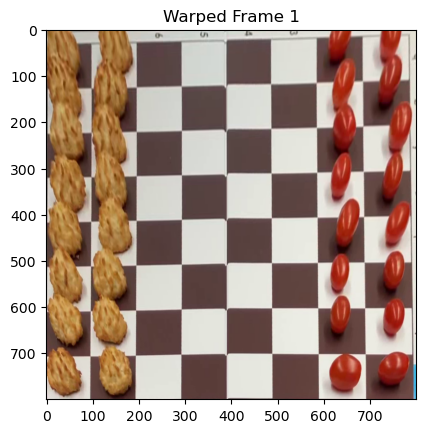

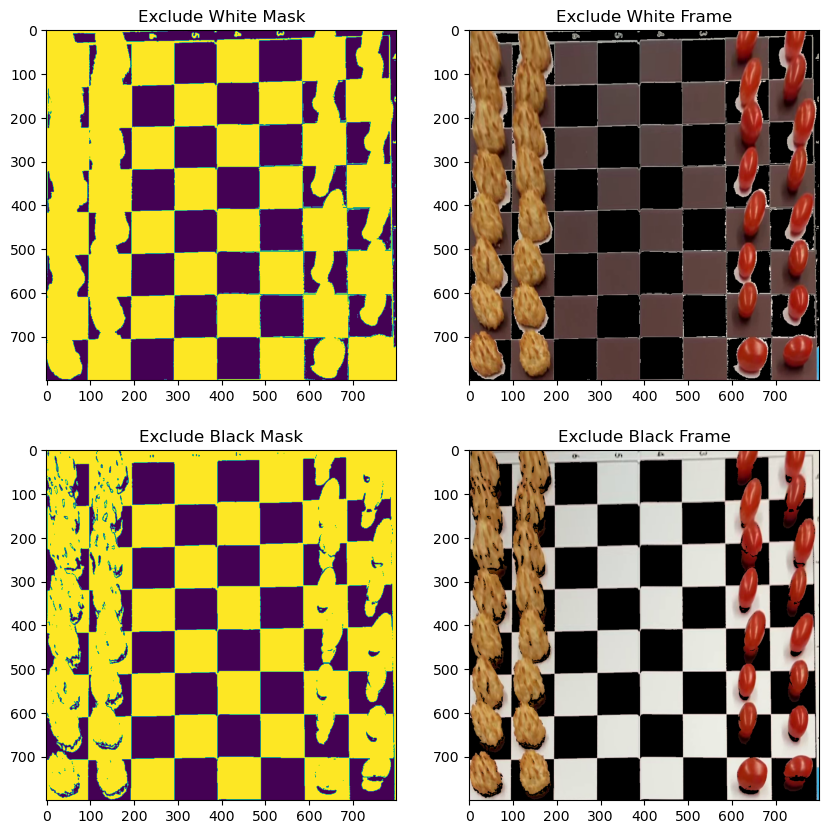

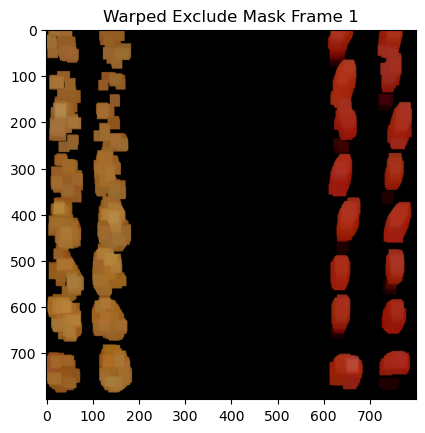

(70, 2)
Number of vertical lines: 40
Number of horizontal lines: 20
Number of vertical lines clustered: 9
Number of horizontal lines clustered: 9
Final vertical lines: 9
Final horizontal lines: 9


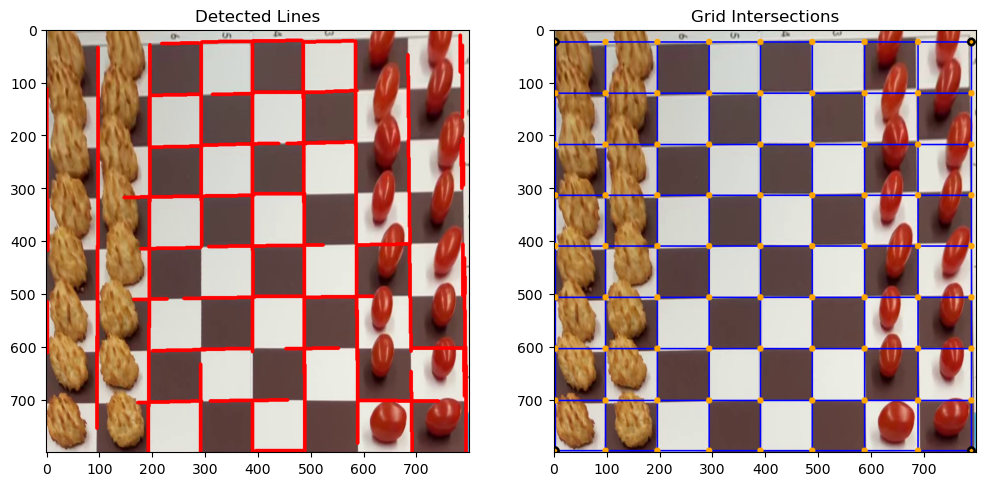

Cell (0, 0) ROI shape: (56, 56, 3) : 3-channel
Cell (0, 1) ROI shape: (58, 58, 3) : 3-channel
Cell (0, 2) ROI shape: (58, 58, 3) : 3-channel
Cell (0, 3) ROI shape: (58, 58, 3) : 3-channel
Cell (0, 4) ROI shape: (58, 58, 3) : 3-channel
Cell (0, 5) ROI shape: (58, 58, 3) : 3-channel
Cell (0, 6) ROI shape: (58, 1, 3) : 3-channel
Empty ROI for cell (0, 7), using 3x3 fallback.
Cell (0, 7) ROI shape: (3, 0, 3) : 3-channel
Cell (1, 0) ROI shape: (56, 56, 3) : 3-channel
Cell (1, 1) ROI shape: (58, 58, 3) : 3-channel
Cell (1, 2) ROI shape: (58, 58, 3) : 3-channel
Cell (1, 3) ROI shape: (58, 58, 3) : 3-channel
Cell (1, 4) ROI shape: (58, 58, 3) : 3-channel
Cell (1, 5) ROI shape: (58, 58, 3) : 3-channel
Cell (1, 6) ROI shape: (58, 1, 3) : 3-channel
Empty ROI for cell (1, 7), using 3x3 fallback.
Cell (1, 7) ROI shape: (3, 0, 3) : 3-channel
Cell (2, 0) ROI shape: (56, 56, 3) : 3-channel
Cell (2, 1) ROI shape: (56, 56, 3) : 3-channel
Cell (2, 2) ROI shape: (56, 56, 3) : 3-channel
Cell (2, 3) ROI sha

c:\Users\User\miniconda3\envs\yolo8\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\User\miniconda3\envs\yolo8\lib\site-packages\numpy\core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


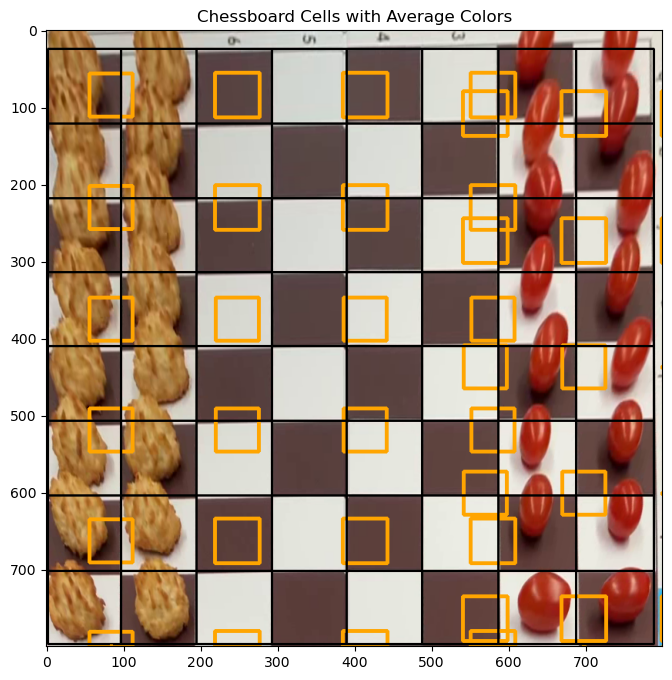

Cell colors (BGR): 64


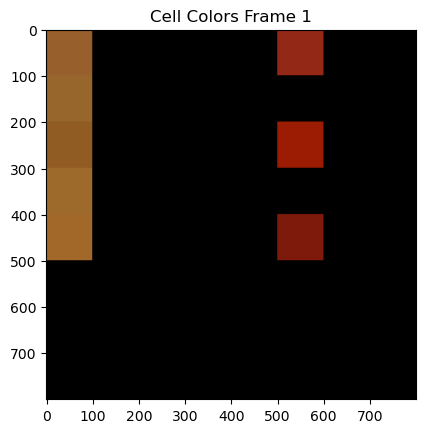

corners 
 {'h8': [496, 324], 'h1': [1289, 338], 'a8': [241, 815], 'a1': [1527, 809]}
pts 
 [[ 496  324]
 [1289  338]
 [1527  809]
 [ 241  815]]


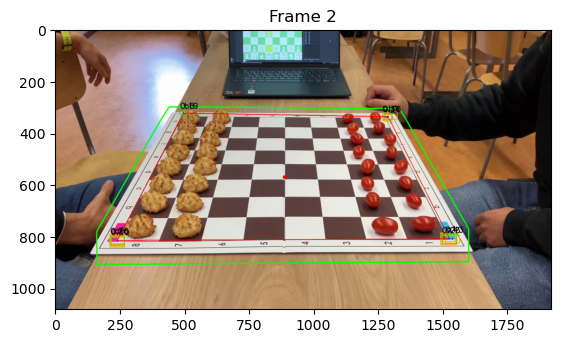

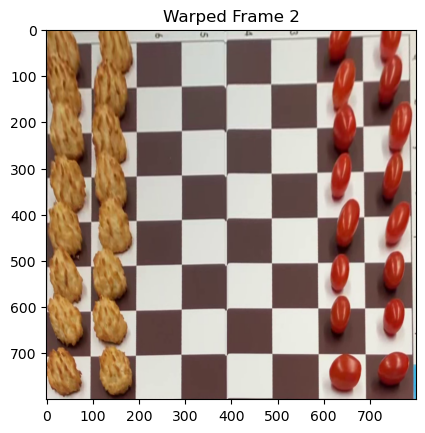

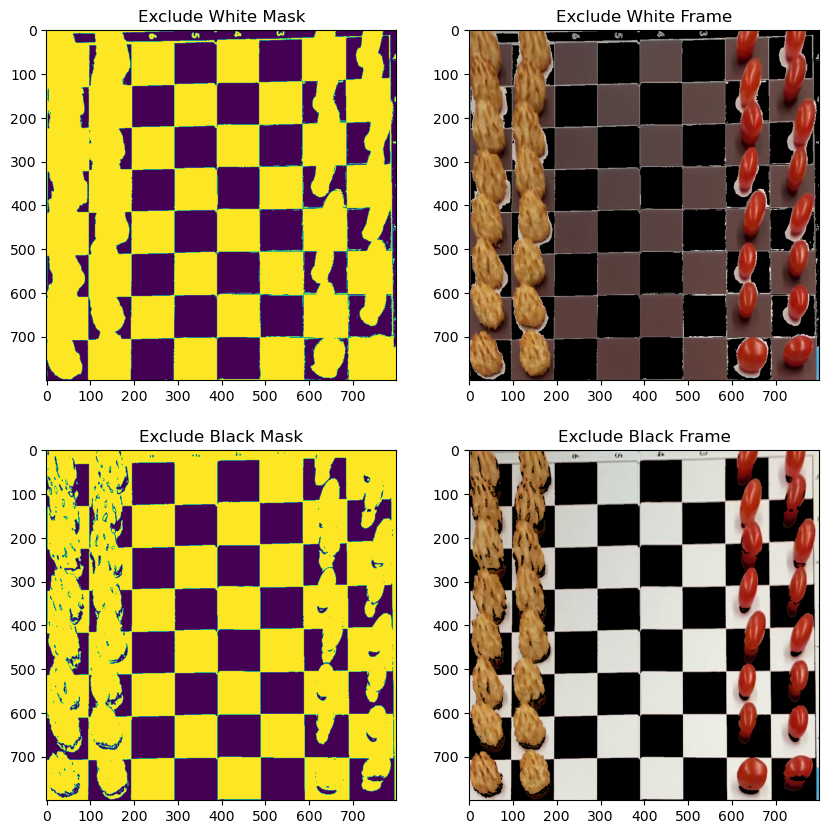

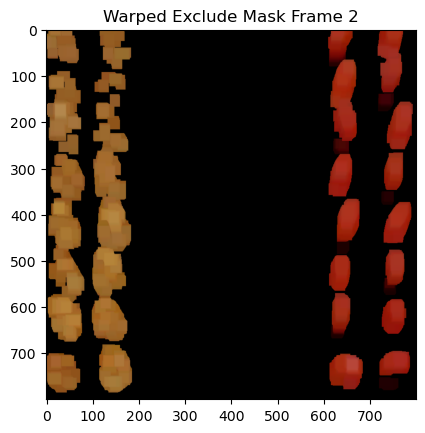

(66, 2)
Number of vertical lines: 36
Number of horizontal lines: 20
Number of vertical lines clustered: 9
Number of horizontal lines clustered: 9
Final vertical lines: 9
Final horizontal lines: 9


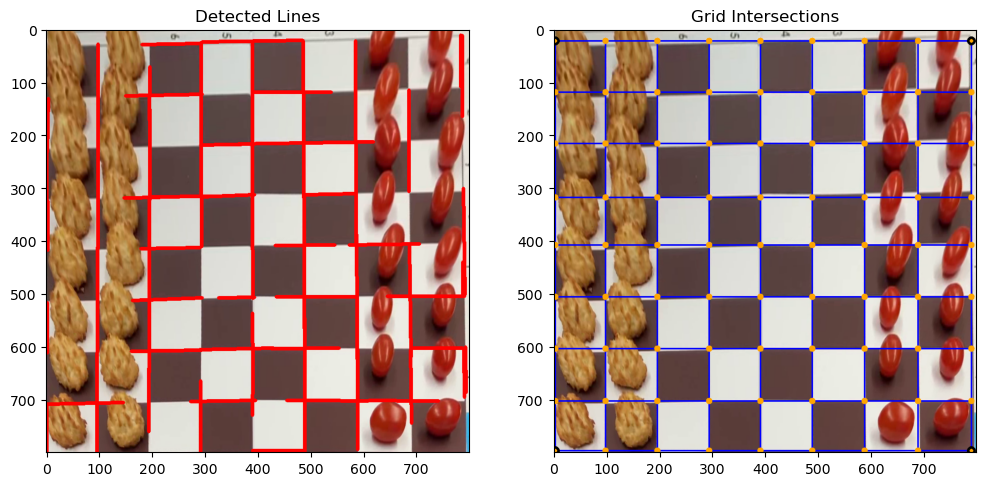

Cell (0, 0) ROI shape: (56, 56, 3) : 3-channel
Cell (0, 1) ROI shape: (58, 58, 3) : 3-channel
Cell (0, 2) ROI shape: (58, 58, 3) : 3-channel
Cell (0, 3) ROI shape: (58, 58, 3) : 3-channel
Cell (0, 4) ROI shape: (58, 58, 3) : 3-channel
Cell (0, 5) ROI shape: (58, 58, 3) : 3-channel
Cell (0, 6) ROI shape: (58, 1, 3) : 3-channel
Empty ROI for cell (0, 7), using 3x3 fallback.
Cell (0, 7) ROI shape: (3, 0, 3) : 3-channel
Cell (1, 0) ROI shape: (56, 56, 3) : 3-channel
Cell (1, 1) ROI shape: (58, 58, 3) : 3-channel
Cell (1, 2) ROI shape: (58, 58, 3) : 3-channel
Cell (1, 3) ROI shape: (58, 58, 3) : 3-channel
Cell (1, 4) ROI shape: (58, 58, 3) : 3-channel
Cell (1, 5) ROI shape: (58, 58, 3) : 3-channel
Cell (1, 6) ROI shape: (58, 1, 3) : 3-channel
Empty ROI for cell (1, 7), using 3x3 fallback.
Cell (1, 7) ROI shape: (3, 0, 3) : 3-channel
Cell (2, 0) ROI shape: (56, 56, 3) : 3-channel
Cell (2, 1) ROI shape: (58, 58, 3) : 3-channel
Cell (2, 2) ROI shape: (58, 58, 3) : 3-channel
Cell (2, 3) ROI sha

c:\Users\User\miniconda3\envs\yolo8\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\User\miniconda3\envs\yolo8\lib\site-packages\numpy\core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


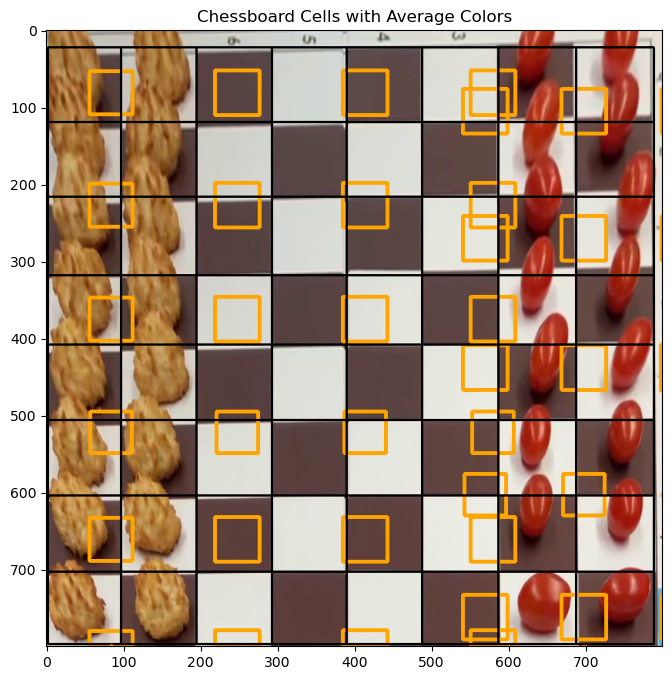

Cell colors (BGR): 64


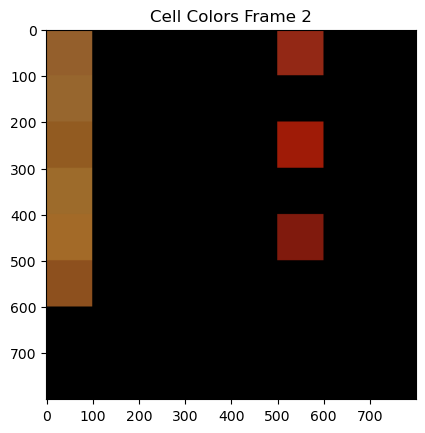

corners 
 {'h8': [493, 290], 'h1': [1286, 298], 'a8': [255, 769], 'a1': [1518, 757]}
pts 
 [[ 493  290]
 [1286  298]
 [1518  757]
 [ 255  769]]


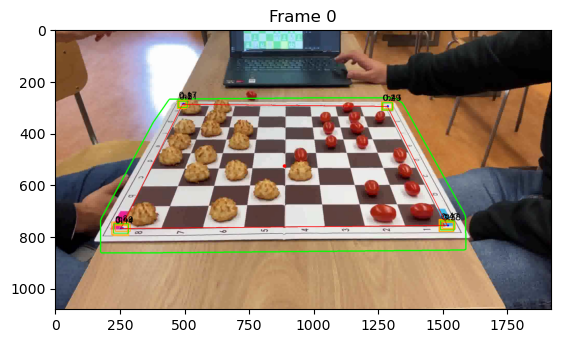

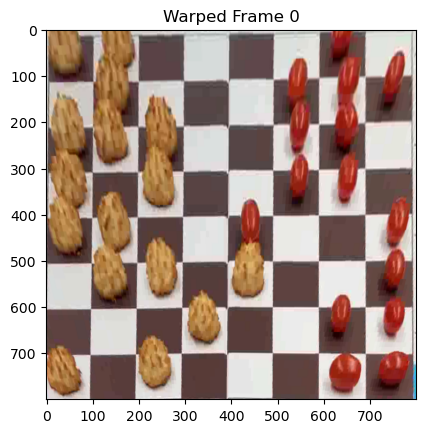

KeyboardInterrupt: 

In [5]:
# !!!!! not use  mov, doesnt work, convert to avi
video_path = r'..\video\IMG_0485.avi'

cap = cv2.VideoCapture(video_path)

# Check if the video opened successfully
if not cap.isOpened():
    print("Error opening the video file")
    exit()
else:
    # Get frame rate information
    fps = int(cap.get(5))
    print("Frame Rate : ",fps,"frames per second")  
    
    # Get frame count, if you see -1, the video is not good
    frame_count = cap.get(7)
    print("Frame count : ", frame_count)

    frame_jump = 0.2 * frame_count
    print("Frame jump : ", frame_jump)
    
    # Get the width and height of frame
    frame_width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
    frame_height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
    print("Frame width : ", frame_width)
    print("Frame height : ", frame_height)

frame_idx = 0

while True:
    ret, frame = cap.read()

    frame_draw = frame.copy()

    if not ret:
        print("End of video stream or error reading the video.")
        break

    corners = corner_id_yolo(frame_draw)

    print(f"corners \n {corners}")

    if all([c[0] is not None and c[1] is not None for c in corners.values()]):
        # [ [x,y], [x,y], ...]
        pts = np.array([
            [int(corners["h8"][0]), int(corners["h8"][1])],
            [int(corners["h1"][0]), int(corners["h1"][1])],
            [int(corners["a1"][0]), int(corners["a1"][1])],
            [int(corners["a8"][0]), int(corners["a8"][1])]
        ], np.int32)

        print(f"pts \n {pts}")

        # shape for polylines (4, 1, 2)
        pts = pts.reshape((-1, 1, 2))
        cv2.polylines(frame_draw, [pts], isClosed=True, color=RED, thickness=2)


    plt.imshow(cv2.cvtColor(frame_draw, cv2.COLOR_BGR2RGB))
    plt.title(f'Frame {frame_idx}')
    plt.show()

    if all([c[0] is not None and c[1] is not None for c in corners.values()]):
        warped_frame = warp_image(frame, corners)
        plt.imshow(cv2.cvtColor(warped_frame, cv2.COLOR_BGR2RGB))
        plt.title(f'Warped Frame {frame_idx}')
        plt.show()

        warped_draw = warped_frame.copy()

        exclude_mask = cleaning_cell_chessboard(warped_draw)
        plt.imshow(exclude_mask)
        plt.title(f'Warped Exclude Mask Frame {frame_idx}')
        plt.show()

        warped_draw = warped_frame.copy()

        inters_pts, external_pts = segmented_grid_chessboard(warped_draw)

        warped_draw = warped_frame.copy()

        cell_colors = get_grid_cells_colors(exclude_mask, inters_pts, external_pts, warped_draw)
        print(f"Cell colors (BGR): {len(cell_colors)}")
        
        warped_draw = warped_frame.copy()

        # Visualize the cell colors
        for r in range(8):
            for c in range(8):
                idx = r * 8 + c
                color = cell_colors[idx]
                x = c * 100
                y = r * 100
                cv2.rectangle(warped_draw, (x, y), (x + 100, y + 100), color, -1)
        plt.imshow(warped_draw)
        plt.title(f'Cell Colors Frame {frame_idx}')
        plt.show()

    frame_idx += 1

    if frame_idx >= 3:
        frame_idx = 0
        # jump ahead by frame_jump frames
        current_pos = cap.get(cv2.CAP_PROP_POS_FRAMES)
        new_pos = min(frame_count - 1, current_pos + frame_jump)
        cap.set(cv2.CAP_PROP_POS_FRAMES, new_pos)
        # break
        
# Release the video capture
cap.release()

# Close all OpenCV windows
cv2.destroyAllWindows()